## Setup

In [1]:
import os
import sys
import torch
import torch.nn.functional as F
import wandb

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'scripts'))

In [51]:
from model import GraphSAGENet
from process_data import DataProcessor
from train import train_epoch_full_graph, evaluate_full_graph

In [16]:
# Initialize wandb
run = wandb.init(
    entity="abdelrahman-helal-minerva-university",
    project="graphsage-experiment",
    config={
        "model": "GraphSAGE",
        "num_layers": 2,
        "hidden_channels": 64,
        "mlp_hidden": 128,
        "learning_rate": 0.01,
        "num_epochs": 100,
        "device": "cpu" if not torch.cuda.is_available() else "cuda"
    },
    mode="online"  # Use online mode to avoid local file issues
)


## Understanding The Data

In [ ]:
data_path = 'D:\Minerva/Senior Year/Capstone/DM_FIREbox_fresh/data/firebox_data/FIREbox_z=0.txt'
data_processor = DataProcessor(file_path=data_path)
preliminary_data = data_processor.load_data()

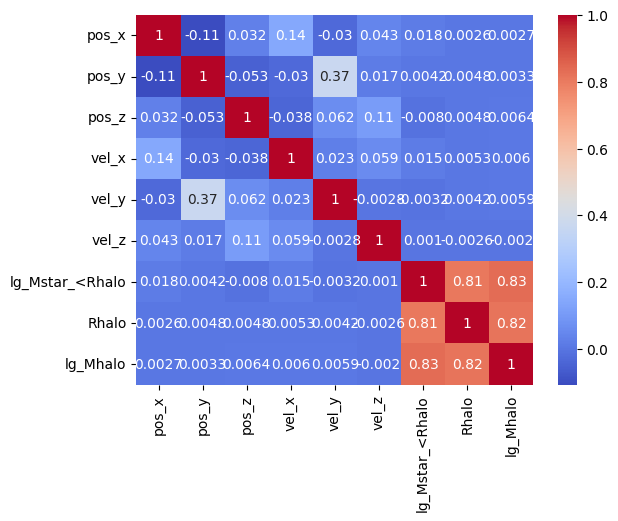

In [31]:
import seaborn as sns
sns.heatmap(preliminary_data[['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z',\
     'lg_Mstar_<Rhalo', 'Rhalo', 'lg_Mhalo']].corr(), annot=True, cmap='coolwarm')
plt.show()

## Model with No Stellar Mass

In [4]:
data_processor.create_graph_data()
data = data_processor.data

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Abdelrahman Helal\AppData\Local\Temp\ipykernel_33296\1600444861.py:1: SyntaxWarning: invalid escape sequence '\M'
  data_path = 'D:\Minerva/Senior Year/Capstone/DM_FIREbox_fresh/data/firebox_data/FIREbox_z=0.txt'


In [5]:
# Training configuration
num_layers = 2
hidden_channels = 64
mlp_hidden = 128
learning_rate = 0.01
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
print(f"Data: {data}")
print(f"Train nodes: {data.train_mask.sum()}")
print(f"Test nodes: {data.test_mask.sum()}")

# for evaluation: sample *all* neighbors (exhaustive) so predictions are stable
val_loader = NeighborLoader(
    data,
    num_neighbors=[-1] * num_layers,   # -1 => take all neighbors at that hop
    input_nodes=data.test_mask,
    batch_size=eval_batch_size,
    shuffle=False,
)

Using device: cpu
Data: Data(x=[160502, 7], edge_index=[2, 1605020], y=[160502, 1], pos=[160502, 3], train_mask=[160502], test_mask=[160502])
Train nodes: 128401
Test nodes: 32101


NameError: name 'NeighborLoader' is not defined

In [17]:
num_layers = 2
hidden_channels = 64
mlp_hidden = 128
learning_rate = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
print(f"Data: {data}")
print(f"Train nodes: {data.train_mask.sum()}")
print(f"Test nodes: {data.test_mask.sum()}")

# Initialize model
model = GraphSAGENet(
    in_channels=data.x.size(1),
    hidden_channels=hidden_channels,
    num_layers=num_layers,
    mlp_hidden=mlp_hidden
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Model: {model}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


Using device: cpu
Data: Data(x=[160502, 7], edge_index=[2, 1605020], y=[160502, 1], pos=[160502, 3], train_mask=[160502], test_mask=[160502])
Train nodes: 128401
Test nodes: 32101
Model: GraphSAGENet(
  (convs): ModuleList(
    (0): SAGEConv(7, 64, aggr=mean)
    (1): SAGEConv(64, 64, aggr=mean)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (mlp): MLPRegressor(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)
Number of parameters: 17921


In [18]:
# Training loop
best_val_rmse = float('inf')
train_losses = []
val_rmses = []
val_maes = []

for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch_full_graph(model, optimizer, data, device)
    train_losses.append(train_loss)
    
    # Evaluation
    val_rmse, val_mae, _, _ = evaluate_full_graph(model, data, device)
    val_rmses.append(val_rmse)
    val_maes.append(val_mae)
    # Log metrics to wandb
    run.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_rmse": val_rmse,
        "val_mae": val_mae,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        # Save best model
        torch.save(model.state_dict(), "../logs/best_model.pt")

    print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

print(f'Best validation RMSE: {best_val_rmse:.4f}')

# Finish wandb run
run.finish()


Epoch 000, Train Loss: 62.3534, Val RMSE: 7.7883, Val MAE: 7.7704
Epoch 001, Train Loss: 60.5567, Val RMSE: 7.6680, Val MAE: 7.6497
Epoch 002, Train Loss: 58.7658, Val RMSE: 7.5471, Val MAE: 7.5282
Epoch 003, Train Loss: 57.0062, Val RMSE: 7.4249, Val MAE: 7.4055
Epoch 004, Train Loss: 55.2443, Val RMSE: 7.3005, Val MAE: 7.2806
Epoch 005, Train Loss: 53.4813, Val RMSE: 7.1733, Val MAE: 7.1528
Epoch 006, Train Loss: 51.6997, Val RMSE: 7.0427, Val MAE: 7.0216
Epoch 007, Train Loss: 49.9320, Val RMSE: 6.9081, Val MAE: 6.8865
Epoch 008, Train Loss: 48.1051, Val RMSE: 6.7691, Val MAE: 6.7469
Epoch 009, Train Loss: 46.2814, Val RMSE: 6.6252, Val MAE: 6.6025
Epoch 010, Train Loss: 44.4312, Val RMSE: 6.4762, Val MAE: 6.4529
Epoch 011, Train Loss: 42.5408, Val RMSE: 6.3216, Val MAE: 6.2976
Epoch 012, Train Loss: 40.6229, Val RMSE: 6.1609, Val MAE: 6.1361
Epoch 013, Train Loss: 38.6493, Val RMSE: 5.9932, Val MAE: 5.9677
Epoch 014, Train Loss: 36.6471, Val RMSE: 5.8178, Val MAE: 5.7914
Epoch 015,

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 099, Train Loss: 0.7141, Val RMSE: 0.4341, Val MAE: 0.3153
Best validation RMSE: 0.4341


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▆▆▅▅▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,███▇▇▆▆▅▄▃▃▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,███▇▇▇▆▆▆▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
learning_rate,0.001
train_loss,0.71406
val_mae,0.31532
val_rmse,0.43406


### Predictions

In [19]:
# Get predictions for the entire dataset
print("Getting predictions for the entire dataset...")
all_predictions = model.predict(data, device)
all_true_values = data.y.view(-1).cpu()

print(f"Predictions shape: {all_predictions.shape}")
print(f"True values shape: {all_true_values.shape}")
print(f"Prediction range: [{all_predictions.min():.4f}, {all_predictions.max():.4f}]")
print(f"True values range: [{all_true_values.min():.4f}, {all_true_values.max():.4f}]")


Getting predictions for the entire dataset...
Predictions shape: torch.Size([160502])
True values shape: torch.Size([160502])
Prediction range: [7.1228, 8.2195]
True values range: [7.1255, 13.0780]


In [20]:
# Get separate predictions for train and test sets
train_test_predictions = model.predict_train_test(data, device)

print("Training set:")
print(f"  Predictions: {train_test_predictions['train_pred'].shape}")
print(f"  True values: {train_test_predictions['train_true'].shape}")

print("Test set:")
print(f"  Predictions: {train_test_predictions['test_pred'].shape}")
print(f"  True values: {train_test_predictions['test_true'].shape}")


Training set:
  Predictions: torch.Size([128401])
  True values: torch.Size([128401])
Test set:
  Predictions: torch.Size([32101])
  True values: torch.Size([32101])


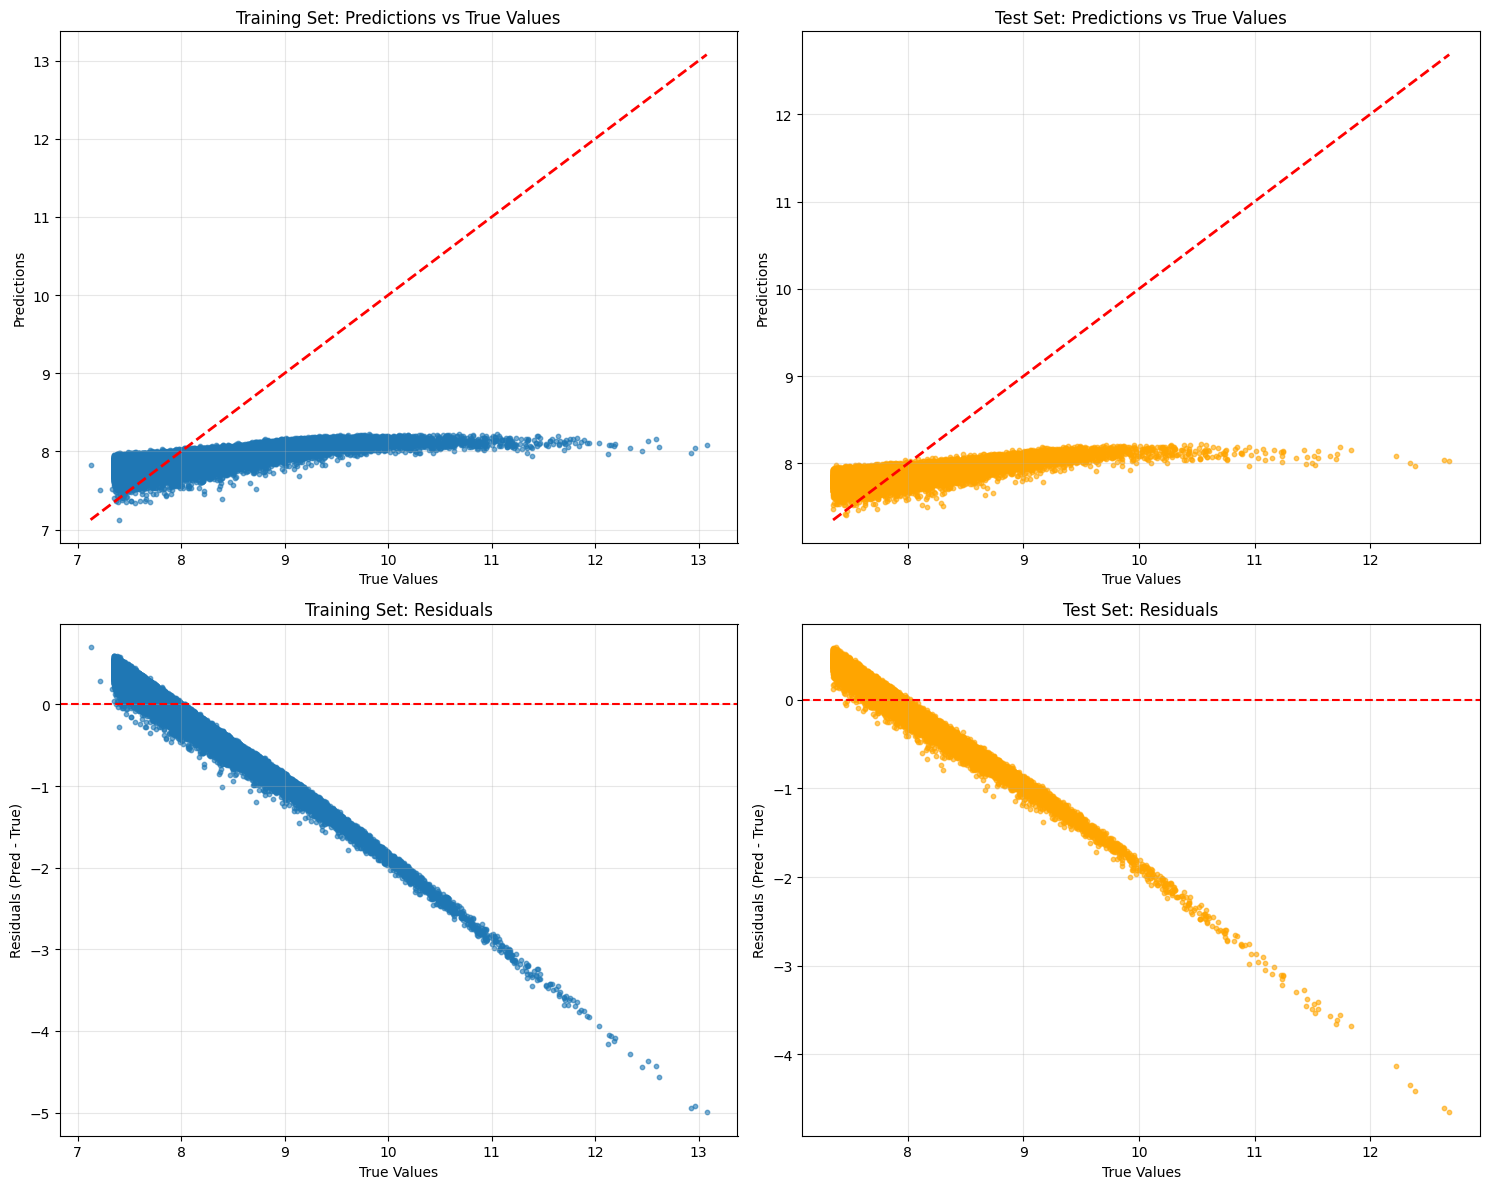

\nPerformance Metrics:
Training RMSE: 0.4323
Test RMSE: 0.4341
Training MAE: 0.3146
Test MAE: 0.3153


In [21]:
# Create visualizations comparing predictions vs true values
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy for plotting
train_pred = train_test_predictions['train_pred'].numpy()
train_true = train_test_predictions['train_true'].numpy()
test_pred = train_test_predictions['test_pred'].numpy()
test_true = train_test_predictions['test_true'].numpy()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training set: Predictions vs True values
axes[0, 0].scatter(train_true, train_pred, alpha=0.6, s=10)
axes[0, 0].plot([train_true.min(), train_true.max()], [train_true.min(), train_true.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predictions')
axes[0, 0].set_title('Training Set: Predictions vs True Values')
axes[0, 0].grid(True, alpha=0.3)

# 2. Test set: Predictions vs True values
axes[0, 1].scatter(test_true, test_pred, alpha=0.6, s=10, color='orange')
axes[0, 1].plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('True Values')
axes[0, 1].set_ylabel('Predictions')
axes[0, 1].set_title('Test Set: Predictions vs True Values')
axes[0, 1].grid(True, alpha=0.3)

# 3. Training set: Residuals
train_residuals = train_pred - train_true
axes[1, 0].scatter(train_true, train_residuals, alpha=0.6, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('True Values')
axes[1, 0].set_ylabel('Residuals (Pred - True)')
axes[1, 0].set_title('Training Set: Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Test set: Residuals
test_residuals = test_pred - test_true
axes[1, 1].scatter(test_true, test_residuals, alpha=0.6, s=10, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('True Values')
axes[1, 1].set_ylabel('Residuals (Pred - True)')
axes[1, 1].set_title('Test Set: Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print performance metrics
train_rmse = np.sqrt(np.mean(train_residuals**2))
test_rmse = np.sqrt(np.mean(test_residuals**2))
train_mae = np.mean(np.abs(train_residuals))
test_mae = np.mean(np.abs(test_residuals))

print(f"\\nPerformance Metrics:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


In [22]:
# Summary Statistics of Predictions vs True Values
mean_pred = np.mean(train_pred)
mean_true = np.mean(train_true)
std_pred = np.std(train_pred)
std_true = np.std(train_true)
min_pred = np.min(train_pred)
min_true = np.min(train_true)
max_pred = np.max(train_pred)
max_true = np.max(train_true)

print(f"Mean Pred: {mean_pred:.4f}, Mean True: {mean_true:.4f}")
print(f"Std Pred: {std_pred:.4f}, Std True: {std_true:.4f}")
print(f"Min Pred: {min_pred:.4f}, Min True: {min_true:.4f}")
print(f"Max Pred: {max_pred:.4f}, Max True: {max_true:.4f}")


Mean Pred: 7.8526, Mean True: 7.8554
Std Pred: 0.0933, Std True: 0.4980
Min Pred: 7.1228, Min True: 7.1255
Max Pred: 8.2195, Max True: 13.0780


## Model with Stellar Mass

In [52]:
run_stellar_mass = wandb.init(
    entity="abdelrahman-helal-minerva-university",
    project="graphsage-experiment",
    config={
        "model": "GraphSAGE",
        "num_layers": 2,
        "hidden_channels": 64,
        "mlp_hidden": 128,
        "learning_rate": 0.01,
        "num_epochs": 100,
        "device": "cpu" if not torch.cuda.is_available() else "cuda"
    },
    mode="online"  # Use online mode to avoid local file issues
)


In [53]:
data_processor_stellar_mass = DataProcessor(file_path=data_path)
data_processor_stellar_mass.create_graph_data(include_lg_Mstar=True)
data_stellar_mass = data_processor_stellar_mass.data

print(f"Data: {data_stellar_mass}")
print(f"Train nodes: {data_stellar_mass.train_mask.sum()}")
print(f"Test nodes: {data_stellar_mass.test_mask.sum()}")

# Initialize model
model_stellar_mass = GraphSAGENet(
    in_channels=data_stellar_mass.x.size(1),
    hidden_channels=hidden_channels,
    num_layers=num_layers,
    mlp_hidden=mlp_hidden
).to(device)

optimizer = torch.optim.Adam(model_stellar_mass.parameters(), lr=learning_rate)

print(f"Model: {model_stellar_mass}")
print(f"Number of parameters: {sum(p.numel() for p in model_stellar_mass.parameters())}")


Data: Data(x=[6213, 8], edge_index=[2, 62130], y=[6213, 1], pos=[6213, 3], train_mask=[6213], test_mask=[6213])
Train nodes: 4970
Test nodes: 1243
Model: GraphSAGENet(
  (convs): ModuleList(
    (0): SAGEConv(8, 64, aggr=mean)
    (1): SAGEConv(64, 64, aggr=mean)
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (mlp): MLPRegressor(
    (mlp): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)
Number of parameters: 18049


In [54]:
# Training loop
best_val_rmse_stellar_mass = float('inf')
train_losses_stellar_mass = []
val_rmses_stellar_mass = []
val_maes_stellar_mass = []

for epoch in range(num_epochs):
    # Training
    train_loss = train_epoch_full_graph(model_stellar_mass, optimizer, data_stellar_mass, device)
    train_losses_stellar_mass.append(train_loss)
    
    # Evaluation
    val_rmse, val_mae, _, _ = evaluate_full_graph(model_stellar_mass, data_stellar_mass, device)
    val_rmses_stellar_mass.append(val_rmse)
    val_maes_stellar_mass.append(val_mae)
    # Log metrics to wandb
    run_stellar_mass.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_rmse": val_rmse,
        "val_mae": val_mae,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    if val_rmse < best_val_rmse_stellar_mass:
        best_val_rmse_stellar_mass = val_rmse
        # Save best model
        torch.save(model_stellar_mass.state_dict(), "../logs/best_model.pt")
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

print(f'Best validation RMSE: {best_val_rmse_stellar_mass:.4f}')

# Finish wandb run
run_stellar_mass.finish()

Epoch 000, Train Loss: 85.8563, Val RMSE: 9.1451, Val MAE: 9.1148
Epoch 010, Train Loss: 66.9262, Val RMSE: 7.9827, Val MAE: 7.9473
Epoch 020, Train Loss: 42.8291, Val RMSE: 6.2153, Val MAE: 6.1691
Epoch 030, Train Loss: 15.6500, Val RMSE: 3.4419, Val MAE: 3.3609
Epoch 040, Train Loss: 1.6738, Val RMSE: 0.7318, Val MAE: 0.5479
Epoch 050, Train Loss: 2.9610, Val RMSE: 1.5217, Val MAE: 1.3878
Epoch 060, Train Loss: 1.4545, Val RMSE: 0.7680, Val MAE: 0.6069
Epoch 070, Train Loss: 1.3718, Val RMSE: 0.7614, Val MAE: 0.5793
Epoch 080, Train Loss: 1.1840, Val RMSE: 0.6666, Val MAE: 0.4978
Epoch 090, Train Loss: 1.1325, Val RMSE: 0.6673, Val MAE: 0.5065


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Best validation RMSE: 0.6264


epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,███▇▇▆▆▆▆▅▄▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,██▇▇▇▆▅▅▄▄▃▃▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_rmse,███▇▇▇▆▆▆▅▅▅▄▄▃▃▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,99
learning_rate,0.001
train_loss,1.02366
val_mae,0.46815
val_rmse,0.6264


Getting predictions for the entire dataset...


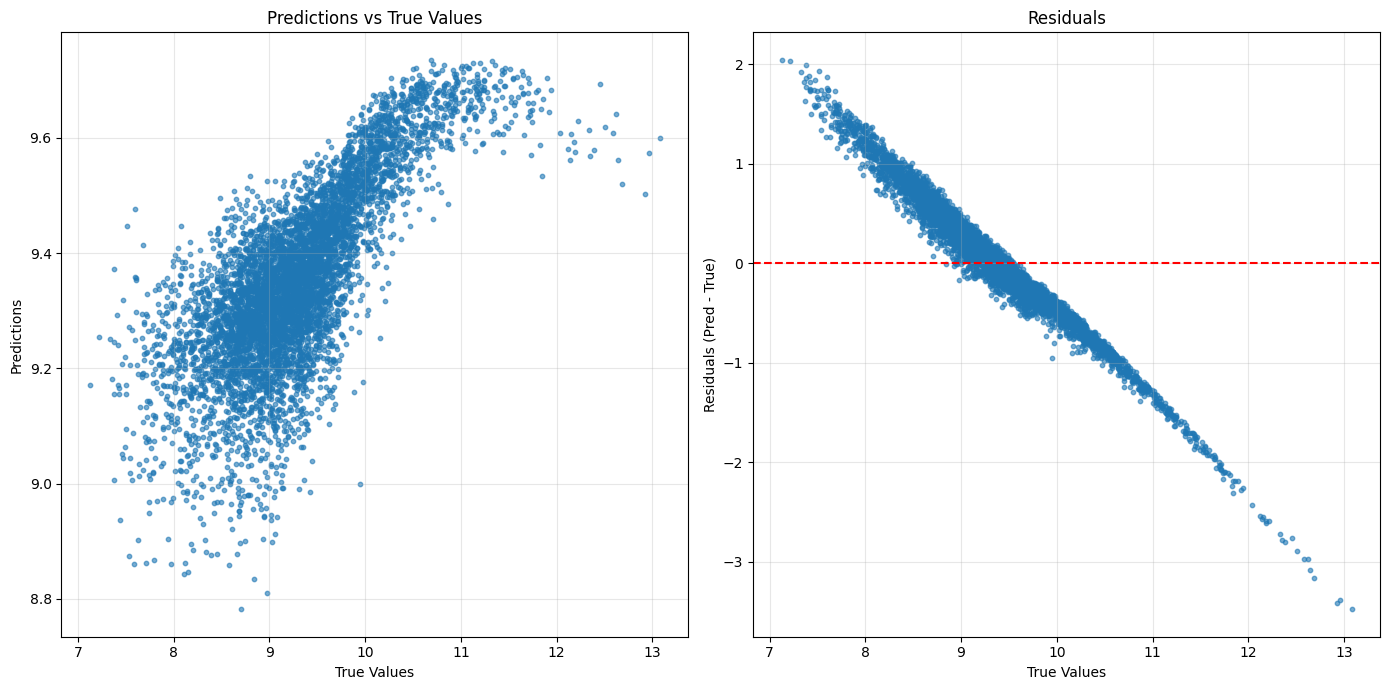

In [55]:
print("Getting predictions for the entire dataset...")
all_predictions_stellar_mass = model_stellar_mass.predict(data_stellar_mass, device)
all_true_values_stellar_mass = data_stellar_mass.y.view(-1).cpu()
residuals_stellar_mass = all_predictions_stellar_mass - all_true_values_stellar_mass

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].scatter(all_true_values_stellar_mass, all_predictions_stellar_mass, alpha=0.6, s=10)
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predictions')
ax[0].set_title('Predictions vs True Values')
ax[0].grid(True, alpha=0.3)

ax[1].scatter(all_true_values_stellar_mass, residuals_stellar_mass, alpha=0.6, s=10)
ax[1].axhline(y=0, color='r', linestyle='--')
ax[1].set_xlabel('True Values')
ax[1].set_ylabel('Residuals (Pred - True)')
ax[1].set_title('Residuals')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()